## Define a Model 

We can use co-connect-tools to create destination tables and fields for our synthetic data model

In [1]:
from carrot.cdm.objects.common import DestinationTable, DestinationField

class Demographics(DestinationTable):
    name = 'Demo'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Age = DestinationField(dtype="Integer", required=False)
        self.Sex = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)

class Symptoms(DestinationTable):
    name = 'Symptoms'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_occurrence = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.Headache = DestinationField(dtype="Text50", required=False )
        self.Fatigue = DestinationField(dtype="Text50", required=False )
        self.Dizzy = DestinationField(dtype="Text50", required=False )
        self.Cough = DestinationField(dtype="Text50", required=False )
        self.Fever = DestinationField(dtype="Text50", required=False )
        self.Muscle_Pain = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class GP_Records(DestinationTable):
    name = 'GP_Records'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_visit = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.comorbidity = DestinationField(dtype="Text50", required=False )
        self.comorbidity_value = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Hospital_Visit(DestinationTable):
    name = 'Hospital_Visit'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.admission_date = DestinationField(dtype="Timestamp", required=False)   
        self.reason = DestinationField(dtype="Text50", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Blood_Test(DestinationTable):
    name = 'Blood_Test'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_taken = DestinationField(dtype="Timestamp", required=False)   
        self.location = DestinationField(dtype="Text50", required=False )
        self.quantity = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)
        
class Vaccinations(DestinationTable):
    name = 'Vaccinations'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.date_of_vaccination = DestinationField(dtype="Timestamp", required=False)                                                                                     
        self.type = DestinationField(dtype="Text50", required=False)
        self.stage = DestinationField(dtype="Integer", required=False)
        super().__init__(self.name,type(self).__name__) 
        
        
class Serology(DestinationTable):
    name = 'Serology'
    def __init__(self,name=None,**kwargs):
        self.ID = DestinationField(dtype="Text50", required=True)
        self.Date = DestinationField(dtype="Timestamp", required=True)
        self.IgG = DestinationField(dtype="Float", required=False )
        super().__init__(self.name,type(self).__name__)


Then build a total model(dataset) based upon these tables, creating this with 50k people

In [15]:
import pandas as pd
import numpy as np
import datetime
import time
import io
import carrot.n
from carrot.cdm import CommonDataModel
from carrot.cdm import define_table

def create_gaus_time_series(mu,sigma,n):
    mu = time.mktime(mu.timetuple())
    sigma = (datetime.timedelta(**sigma)).total_seconds()
    return pd.Series([datetime.date.fromtimestamp(x) for x in np.random.normal(mu,sigma,n)])

class ExampleCovid19DataSet(CommonDataModel):
    def __init__(self):
        """                                                                                                                                                    
        initialise the inputs and setup indexing                                                                                                               
        """  
        #50k people
        n = 5000000
        
        #initial the model, give an output location and specify we want to save the model into csv files 
        super().__init__(output_folder=f'./synthetic_data/{n}/',format_level=0,outfile_separator=',')

        #create people indexes that we can use in the different tables
        self.people = pd.DataFrame([f'pk{i}' for i in range(1,n+1)],columns=['pks'])
        
        #set the processing order, e.g we want to build demographics table first
        #so that the values recorded in other tables can be demographically dependent 
        self.set_execution_order([
            'Demographics', 
            'GP_Records', 
            'Vaccinations',
            'Serology',
            'Symptoms',
            'Hospital_Visit',
            'Blood_Test'
        ])
        self.process()
      
    @define_table(Demographics)
    def demo(self):  
        """
        Straight foreward demographics
        """
        self.ID.series = self.cdm.people['pks']
        self.n = len(self.ID.series)
        self.Age.series = pd.Series(np.random.normal(60,20,self.n)).astype(int)
        self.Age.series = self.Age.series.mask(self.Age.series < 0 , None)
        self.Sex.series = pd.Series(np.random.choice(['Male','Female',None],size=self.n,p=[0.55,0.445,0.005]))
        
        
    @define_table(Symptoms)
    def symptoms(self):
        npeople = self.cdm.demo.n
        nsymptoms = npeople*5

        ID = self.cdm.demo.ID.series
        
        self.ID.series = ID.sample(int(npeople*0.8))\
            .sample(nsymptoms,replace=True)\
            .sort_values().reset_index(drop=True)  

        self.date_occurrence.series = create_gaus_time_series(mu=datetime.datetime(2021,1,1),
                                                              sigma={'days':365},
                                                              n=nsymptoms)
        
        self.date_occurrence.series.loc[self.date_occurrence.series.sample(frac=0.005).index] = np.nan
        
        syms_probs = {'Headache':0.8,'Fatigue':0.7,'Dizzy':0.4,'Cough':0.7,'Fever':0.2,'Muscle_Pain':0.1}
        for key,p in syms_probs.items():
            series = pd.Series(np.random.choice(['Yes','No'],size=nsymptoms,p=[p,1-p]))
            setattr(getattr(self,key),'series',series)
            
    @define_table(Serology)
    def serology(self):
        
        def calc_IgG(age,sex,nrisks):
            scale = 50*(1 - age/200)*(1.1 if sex=='Female' else 1.0)*(1/nrisks)
            return np.random.exponential(scale=scale)
        
        df_gp = self.cdm.gp.get_df()
        df_nrisks = df_gp['comorbidity'].groupby(df_gp.index)\
                    .count()
        df_nrisks.name ='nrisks'

        df = self.cdm.demo.get_df().join(df_nrisks).reset_index()
        df['nrisks'] = df['nrisks'].fillna(1)

        df = df[df['Age']>18].sample(frac=0.3)
        nstudies = len(df)

        df = df.sample(frac=1.4,replace=True).reset_index()

        df['IgG'] = df.apply(lambda x : calc_IgG(x.Age,x.Sex,x.nrisks),axis=1)
        df.sort_values('ID',inplace=True)
        
        self.IgG.series = df['IgG']
        self.ID.series = df['ID']
        self.Date.series = create_gaus_time_series(mu=datetime.datetime(2021,5,1),
                                                              sigma={'days':365},
                                                              n=len(df))
           
    @define_table(GP_Records)
    def gp(self):
    
        def calc_comoribidites(age):
            if pd.isna(age):
                return []   
            comorbidities = {
                'Mental Health':0.3*(1 + age/90) ,
                'Diabetes Type-II':0.15*(1 + age/70) ,
                'Heart Condition':0.1*(1 + age/50) ,
                'High Blood Pressure':0.07*(1 + age/60),
                'BMI': 1
            }
            return [x for x,p in comorbidities.items() if np.all(np.random.uniform() < p) ]
        
        #90% of people have a GP visit record
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        df['comorbidity'] = df.apply(lambda x: calc_comoribidites(x.Age),axis=1)
        df['date_of_observation'] = create_gaus_time_series(mu=datetime.datetime(2010,5,1),
                                                              sigma={'days':700},
                                                              n=len(df))
        
        df = df.explode('comorbidity').set_index('ID').sort_index()
    
        self.ID.series = df.index.to_series()
        self.comorbidity.series = df['comorbidity']
        self.comorbidity_value.series = df['comorbidity'].apply(lambda x: np.random.exponential(scale=20)
                                                                if x == 'BMI' else 1)
        self.date_of_visit.series = df['date_of_observation']
        
    @define_table(Hospital_Visit) 
    def hospital(self):
        
        n = len(self.cdm.demo.ID.series)
        
        #5% of people have had a hospital visit
        #some of those have multiple visists
        self.ID.series = self.cdm.demo.ID.series.sample(n)\
                        .sample(int(n*1.2),replace=True)\
                        .sort_values().reset_index(drop=True)  
        
        n = len(self.ID.series)
        self.admission_date.series = create_gaus_time_series(mu=datetime.datetime(2020,5,1),
                                                              sigma={'days':300},
                                                              n=n)
    
        reasons = {
            'Kidney Operation':0.1,
            'Appendix Operation':0.1,
            'Heart Attack':0.2,
            'COVID-19':0.15,
            'Pneumonia':0.15,
            'Cancer':0.3
        }

        self.reason.series = pd.Series(np.random.choice(list(reasons.keys()),size=n,p=list(reasons.values())))

    @define_table(Blood_Test)
    def bloods(self):
        #half of the people with hospital visits have blood taken
        df_hospital = self.cdm.hospital.get_df().sample(frac=0.5).reset_index()
        
        self.ID.series = df_hospital['ID']
        self.date_taken.series = pd.to_datetime(df_hospital['admission_date']) \
                               + datetime.timedelta(days=np.random.uniform(0,5))
        
        n = len(df_hospital)
        self.location.series = pd.Series(np.random.choice(['Right Arm','Left Arm','Small Intestine','Abdominal Wall'],
                                                   size=n,
                                                   p=[0.3,0.3,0.2,0.2]))
        self.quantity.series = pd.Series((np.random.exponential(scale=1.5) for _ in range(0,n)))
        
    @define_table(Vaccinations)
    def first_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #95% of people have had a vaccination
        df = self.cdm.demo.get_df().sample(frac=0.9).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  df.apply(lambda x : calc_date_of_vacc(x.Age),axis=1)
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((0 for _ in range(0,n)))
       
    @define_table(Vaccinations)
    def second_covid_vaccination(self):
        
        def calc_date_of_vacc(age):
            if pd.isna(age):
                return np.nan
            start_date = datetime.datetime(2021,1,1)
            tdelta = datetime.timedelta(days=(300-age*2)+np.random.uniform(0,50))
            
            return start_date + tdelta
            
        #80% of people who had 1st had 2nd
        df = self.cdm.first_covid_vaccination.get_df().sample(frac=0.8).reset_index()
        
        self.ID.series = df['ID']
        self.date_of_vaccination.series =  pd.to_datetime(df['date_of_vaccination']) \
                                           + datetime.timedelta(days=(50+np.random.uniform(0,50)))
        n = len(self.ID.series)
        self.type.series = pd.Series(np.random.choice(['Moderna','AstraZenica','Pfizer'],size=n,p=[0.34,0.33,0.33]))
        self.stage.series = pd.Series((1 for _ in range(0,n)))
        
        
     

## Create a Model
Create and run the model, for a dataset so large and complex, this can take some time

In [ ]:
model = ExampleCovid19DataSet()
model

2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - CommonDataModel (5.3.1) created with co-connect-tools version 0.0.0
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Running with the output to be dumped to a folder './synthetic_data/5000000/'
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Turning on automatic cdm column filling
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added bloods of type Blood_Test
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added demo of type Demographics
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added first_covid_vaccination of type Vaccinations
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added gp of type GP_Records
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added hospital of type Hospital_Visit
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added second_covid_vaccination of type Vaccinations
2022-02-09 15:25:55 - ExampleCovid19DataSet - INFO - Added serology of type Serology
2022-02-09 15:25:55 

## Viewing the Model

Print to see what output data tables the model contains

In [4]:
model.keys()

dict_keys(['Demographics', 'GP_Records', 'Vaccinations', 'Serology', 'Symptoms', 'Hospital_Visit', 'Blood_Test'])

retrieve the dataframes from the model

In [5]:
model['Demographics'].get_df()

,Age,Sex
ID,,
pk1,18,Female
pk10,44,Male
pk100,55,Female
pk1000,94,Male
pk10000,44,Female
...,...,...
pk9995,80,Male
pk9996,75,Male
pk9997,68,Female


In [6]:
model['GP_Records'].get_df()

,date_of_visit,comorbidity,comorbidity_value
ID,,,
pk1,2009-01-29 00:00:00.000000,BMI,0.599398
pk10,2009-09-02 00:00:00.000000,BMI,8.8568
pk100,2008-12-05 00:00:00.000000,BMI,2.96668
pk10000,2013-08-18 00:00:00.000000,Mental Health,1.0
pk10000,2013-08-18 00:00:00.000000,Diabetes Type-II,1.0
...,...,...,...
pk9997,2010-11-23 00:00:00.000000,Diabetes Type-II,1.0
pk9997,2010-11-23 00:00:00.000000,BMI,1.904499
pk9998,2008-12-13 00:00:00.000000,Heart Condition,1.0


In [7]:
model['Vaccinations'].get_df()

,date_of_vaccination,type,stage
ID,,,
pk1,2021-10-29 18:46:14.769166,Moderna,0
pk1,2021-12-21 16:51:09.992962,Pfizer,1
pk10,2021-10-24 13:03:26.531843,Pfizer,1
pk10,2021-09-01 14:58:31.308047,AstraZenica,0
pk100,2021-07-16 01:32:04.115467,Pfizer,0
...,...,...,...
pk9996,2021-07-06 01:15:17.506989,AstraZenica,0
pk9996,2021-08-27 23:20:12.730785,Pfizer,1
pk9997,2021-06-25 22:13:52.791143,Moderna,0


In [8]:
model['Serology'].get_df()

,Date,IgG
ID,,
pk100,2020-01-21 00:00:00.000000,6.527243
pk10002,2019-03-18 00:00:00.000000,13.328022
pk10002,2019-09-30 00:00:00.000000,12.542834
pk10002,2021-02-05 00:00:00.000000,14.665543
pk10003,2022-07-17 00:00:00.000000,18.313551
...,...,...
pk9984,2020-12-14 00:00:00.000000,0.380631
pk999,2021-04-04 00:00:00.000000,4.554027
pk999,2021-04-14 00:00:00.000000,2.833613


In [9]:
model['Symptoms'].get_df()

,date_occurrence,Headache,Fatigue,Dizzy,Cough,Fever,Muscle_Pain
ID,,,,,,,
pk1,2020-12-08 00:00:00.000000,Yes,Yes,Yes,Yes,No,Yes
pk1,2020-05-13 00:00:00.000000,No,Yes,Yes,No,No,No
pk1,2020-11-26 00:00:00.000000,Yes,Yes,Yes,No,No,No
pk1,2021-08-21 00:00:00.000000,Yes,No,No,Yes,No,No
pk1,2020-08-22 00:00:00.000000,Yes,Yes,No,No,No,No
...,...,...,...,...,...,...,...
pk9999,2019-12-26 00:00:00.000000,Yes,Yes,No,Yes,No,No
pk9999,2021-06-04 00:00:00.000000,No,Yes,No,Yes,No,No
pk9999,2020-10-26 00:00:00.000000,Yes,No,No,Yes,Yes,No


In [10]:
model['Blood_Test'].get_df()

,date_taken,location,quantity
ID,,,
pk10,2021-10-06 03:13:58.156761,Right Arm,3.515808
pk100,2019-07-16 03:13:58.156761,Abdominal Wall,1.604297
pk100,2021-02-19 03:13:58.156761,Abdominal Wall,4.266723
pk10000,2021-09-11 03:13:58.156761,Left Arm,0.953679
pk10001,2020-07-18 03:13:58.156761,Abdominal Wall,2.691753
...,...,...,...
pk9996,2021-05-17 03:13:58.156761,Abdominal Wall,8.100997
pk9998,2021-01-10 03:13:58.156761,Abdominal Wall,1.221517
pk9999,2021-11-06 03:13:58.156761,Left Arm,0.885999


In [11]:
model['Hospital_Visit'].get_df()

,admission_date,reason
ID,,
pk1,2020-10-28 00:00:00.000000,Cancer
pk10,2020-01-01 00:00:00.000000,Heart Attack
pk10,2021-10-03 00:00:00.000000,Kidney Operation
pk100,2019-07-13 00:00:00.000000,Pneumonia
pk100,2021-02-16 00:00:00.000000,Cancer
...,...,...
pk9996,2020-04-10 00:00:00.000000,Heart Attack
pk9998,2021-01-07 00:00:00.000000,Appendix Operation
pk9999,2021-08-15 00:00:00.000000,Cancer


## Perform analysis

Firstly get the the GP records, and count the number of comorbidities a patient has, to create risk groups

In [12]:
df_gp = model['GP_Records'].get_df()
df_nrisks = df_gp.groupby(df_gp.index)['comorbidity'].count() - 1
df_nrisks.name = 'nrisks'
df_nrisks.value_counts().to_frame().sort_index()

,nrisks
0,11157
1,19669
2,11299
3,2652
4,223


build a dataframe for analysis by getting the serology data + demographics data + the number of risks

In [13]:
df = model['Serology'].get_df().join(model['Demographics'].get_df()).join(df_nrisks).fillna(0)
df

,Date,IgG,Age,Sex,nrisks
ID,,,,,
pk100,2020-01-21 00:00:00.000000,6.527243,55,Female,0.0
pk10002,2019-03-18 00:00:00.000000,13.328022,75,Male,0.0
pk10002,2019-09-30 00:00:00.000000,12.542834,75,Male,0.0
pk10002,2021-02-05 00:00:00.000000,14.665543,75,Male,0.0
pk10003,2022-07-17 00:00:00.000000,18.313551,62,Female,0.0
...,...,...,...,...,...
pk9984,2020-12-14 00:00:00.000000,0.380631,59,Female,1.0
pk999,2021-04-04 00:00:00.000000,4.554027,67,Male,0.0
pk999,2021-04-14 00:00:00.000000,2.833613,67,Male,0.0


Produce some plots show how there is a difference in the IgG response for different age and risk groups

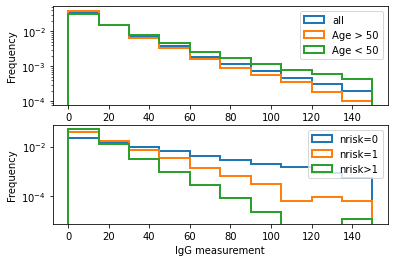

In [14]:
import matplotlib.pyplot as plt
fig,axs = plt.subplots(2)
ax = axs[0]

df['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),histtype='step',lw=2,density=True,label='all')
df[df['Age']>50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age > 50')
df[df['Age']<50]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='Age < 50')
ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()

ax = axs[1]
df[df['nrisks']<1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=0')
df[df['nrisks']==1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk=1')
df[df['nrisks']>1]['IgG'].plot.hist(ax=ax,bins=10,range=(0,150),density=True,histtype='step',lw=2,label='nrisk>1')

ax.set_yscale('log')
ax.set_xlabel('IgG measurement')
ax.legend()
plt.show();